In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import numpy as np

# Loading the data

In [3]:
trk = pd.read_pickle("/media/lucas/QS/l1_nnt/trk_processed_25k.pkl")

In [4]:
trk.head()

trk_pt   trk_eta   trk_phi  trk_d0    trk_z0  trk_fake  \
entry subentry                                                             
0     0         2.623967  1.301414 -0.289234   999.0 -0.878906         2   
      1         3.435026  0.566814 -0.159267   999.0  3.339844         2   
      2         3.774908  1.815973 -0.240375   999.0  4.921875         1   
      3         2.641448 -1.435747 -0.128747   999.0 -0.468750         2   
      4         2.320653  1.837421  0.032604   999.0  4.980469         1   

                is_pv  
entry subentry         
0     0             0  
      1             0  
      2             1  
      3             0  
      4             1

# Data Pre-processing

In [5]:
trk = trk.reset_index()

In [6]:
X = trk[["trk_pt", "trk_eta", "trk_phi", "trk_z0"]]
y = trk["is_pv"]

In [7]:
from sklearn.model_selection import train_test_split

### Creating the train, test and validation sets

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42
)

In [10]:
print("train: ", y_train.shape[0] / y.shape[0])
print("test: ", y_test.shape[0] / y.shape[0])
print("val: ", y_val.shape[0] / y.shape[0])

train:  0.5999998684941883
test:  0.20000017534108225
val:  0.19999995616472943


### Deriving feature scaling from training set

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
scaler = StandardScaler()

In [13]:
scaler.fit(X_train)

StandardScaler()

In [14]:
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)
X_val_sc = scaler.transform(X_val)

### Deriving the reweighting ratio from the training set

In [15]:
R = y_train.sum() / y_train.shape[0]

In [16]:
w_train = np.ones(y_train.shape[0])
w_train[y_train == 0] = R

w_test = np.ones(y_test.shape[0])
w_test[y_test == 0] = R

w_val = np.ones(y_val.shape[0])
w_val[y_val == 0] = R

Data should be ready for training

# Defining the model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [18]:
def nn():
    model = Sequential()
    model.add(Dense(units=64, activation="relu", input_dim=4))
    model.add(Dropout(0.2))
    model.add(Dense(units=32, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

# Training the model

In [19]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [20]:
model = nn()

2022-08-23 16:08:12.838218: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-23 16:08:12.838241: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ironwolf): /proc/driver/nvidia/version does not exist
2022-08-23 16:08:12.838775: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
model.fit(
    X_train_sc,
    y_train,
    epochs=10,
    batch_size=400,
    verbose=1,
    class_weight={0: R, 1: 1},
    validation_data=(X_test_sc, y_test),
    callbacks=[EarlyStopping(monitor="accuracy", patience=10, verbose=True)],
)

Epoch 1/10
6844/6844 [==============================] - 7s 999us/step - loss: 0.1566 - accuracy: 0.7633 - val_loss: 0.5873 - val_accuracy: 0.7708
Epoch 2/10
6844/6844 [==============================] - 7s 974us/step - loss: 0.1538 - accuracy: 0.7745 - val_loss: 0.5752 - val_accuracy: 0.7783
Epoch 3/10
6844/6844 [==============================] - 7s 999us/step - loss: 0.1536 - accuracy: 0.7743 - val_loss: 0.5707 - val_accuracy: 0.7749
Epoch 4/10
6844/6844 [==============================] - 7s 1ms/step - loss: 0.1535 - accuracy: 0.7757 - val_loss: 0.5841 - val_accuracy: 0.7623
Epoch 5/10
6844/6844 [==============================] - 7s 981us/step - loss: 0.1535 - accuracy: 0.7751 - val_loss: 0.5738 - val_accuracy: 0.7856
Epoch 6/10
6844/6844 [==============================] - 7s 976us/step - loss: 0.1535 - accuracy: 0.7763 - val_loss: 0.5867 - val_accuracy: 0.7626
Epoch 7/10
6844/6844 [==============================] - 7s 977us/step - loss: 0.1535 - accuracy: 0.7761 - val_loss: 0.5591 - v

In [22]:
import matplotlib.pyplot as plt

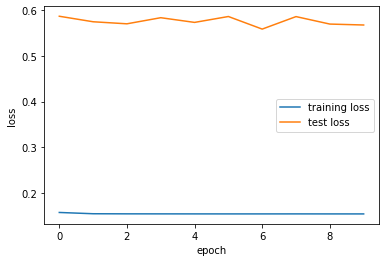

In [23]:
plt.plot(model.history.history["loss"], label="training loss")
plt.plot(model.history.history["val_loss"], label="test loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

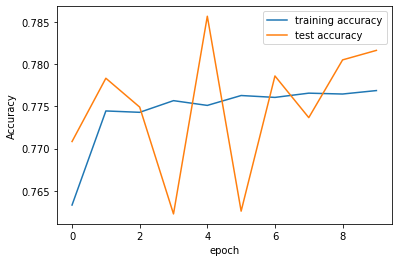

In [24]:
plt.plot(model.history.history["accuracy"], label="training accuracy")
plt.plot(model.history.history["val_accuracy"], label="test accuracy")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()

Seems like the NN learns something initialy but it doesn't get better with age. The much higher loss function in the validation set hints at that it might be overfitted. Let's assess the metrics in the validation dataset

### Classification metrics in validation set

In [25]:
y_val_pred = model.predict(X_val_sc)

28516/28516 [==============================] - 10s 342us/step


In [26]:
from sklearn.metrics import roc_auc_score, roc_curve

In [27]:
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)

In [28]:
auc = roc_auc_score(y_val, y_val_pred)

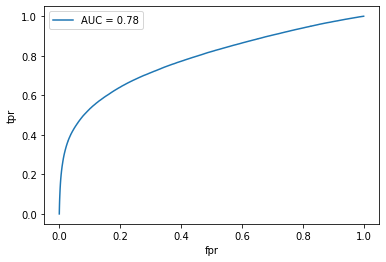

In [29]:
plt.plot(fpr, tpr, label="AUC = %0.2f" % auc)
plt.ylabel("tpr")
plt.xlabel("fpr")
plt.legend()

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [31]:
cm = confusion_matrix(y_val, y_val_pred > 0.5)

In [32]:
cm

array([[626164, 147672],
       [ 50840,  87831]])

Text(0.5, 1.0, 'Normalized over rows')

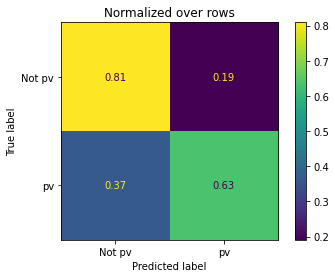

In [33]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_val, y_val_pred > 0.5, display_labels=["Not pv", "pv"], normalize="true"
)
plt.title("Normalized over rows")
# disp.plot()

# Explainability

In [34]:
import shap

In [35]:
e = shap.DeepExplainer(model, X_val_sc[0:1000])

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [36]:
shap_values = e.shap_values(X_val_sc[0:1000])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [43]:
shap.plots.bar(e)

AssertionError: You must pass an Explanation object, Cohorts object, or dictionary to bar plot!

In [50]:
shap_values[0]

array([[-0.1113167 , -0.06856673,  0.00085793,  0.00666795],
       [-0.10818227,  0.03351907,  0.00500038,  0.00473053],
       [-0.09649319, -0.0746944 , -0.00327389, -0.00902729],
       ...,
       [-0.03241649, -0.0164727 ,  0.00025341,  0.00619327],
       [-0.14282522,  0.02300531,  0.00629277, -0.0039153 ],
       [-0.10083601, -0.05734885,  0.00829286, -0.00405514]])

In [47]:
help(shap.plots.bar)

Help on function bar in module shap.plots._bar:

bar(shap_values, max_display=10, order=shap.Explanation.abs, clustering=None, clustering_cutoff=0.5, merge_cohorts=False, show_data='auto', show=True)
    Create a bar plot of a set of SHAP values.
    
    If a single sample is passed then we plot the SHAP values as a bar chart. If an
    Explanation with many samples is passed then we plot the mean absolute value for
    each feature column as a bar chart.
    
    
    Parameters
    ----------
    shap_values : shap.Explanation or shap.Cohorts or dictionary of shap.Explanation objects
        A single row of a SHAP Explanation object (i.e. shap_values[0]) or a multi-row Explanation
        object that we want to summarize.
    
    max_display : int
        The maximum number of bars to display.
    
    show : bool
        If show is set to False then we don't call the matplotlib.pyplot.show() function. This allows
        further customization of the plot by the caller after the ba

In [52]:
shap.plots.bar(e, shap_values[0])

AssertionError: You must pass an Explanation object, Cohorts object, or dictionary to bar plot!